In [1]:
import sys
sys.path.append('../')

from cogsci2017.environment.arm_diva_env import CogSci2017Environment
from cogsci2017.learning.supervisor import Supervisor
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

iterations = 2000

environment = CogSci2017Environment(gui=False, audio=False)


config = dict(m_mins=environment.conf.m_mins,
             m_maxs=environment.conf.m_maxs,
             s_mins=environment.conf.s_mins,
             s_maxs=environment.conf.s_maxs)

agent = Supervisor(config, model_babbling="random", n_motor_babbling=1000, explo_noise=0.05)



human sounds ['euo', 'yeo', 'oiy', 'uie', 'ieu', 'uyi']


Iteration 0


../cogsci2017/environment/diva/diva.py:169: RuntimeWarning: invalid value encountered in log2
  formants = log2(transpose(res[self.s_used,:]))


Iteration 200
Iteration 400
Iteration 600
Iteration 800
best_vocal_errors [('euo', 0.69662562909645442), ('yeo', 0.80183036626726911), ('oiy', 0.59457775099759158), ('uie', 0.92081183823668533), ('ieu', 1.0247547561750139), ('uyi', 0.8926179702535173)]
Iteration 1000
Iteration 1200
Iteration 1400
Iteration 1600
Iteration 1800
best_vocal_errors [('euo', 0.69662562909645442), ('yeo', 0.64581751290417022), ('oiy', 0.59457775099759158), ('uie', 0.92081183823668533), ('ieu', 0.8434597342989778), ('uyi', 0.81222023483238781)]


(-9.25, -7.5)

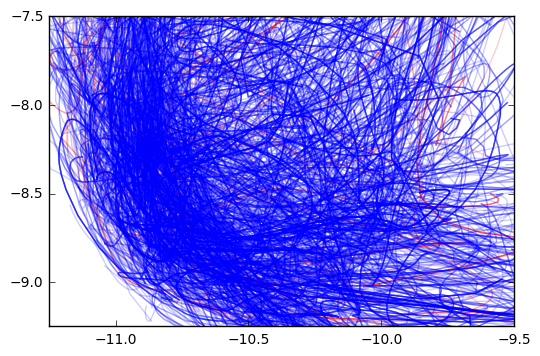

In [2]:
for i in range(iterations):
    if i % (iterations/10) == 0:
        print "Iteration", i
    context = environment.get_current_context()
    m = agent.produce(context)
    s = environment.update(m)
    agent.perceive(s)
    s_traj = environment.diva_traj
    if s_traj is not None:
        if i < 100:
            plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="r", alpha=0.2)
        else:
            plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="b", alpha=0.2)
            
plt.xlim([-11.25,-9.5])
plt.ylim([-9.25, -7.5])

error oiy 0.787985083408


(-9.25, -7.5)

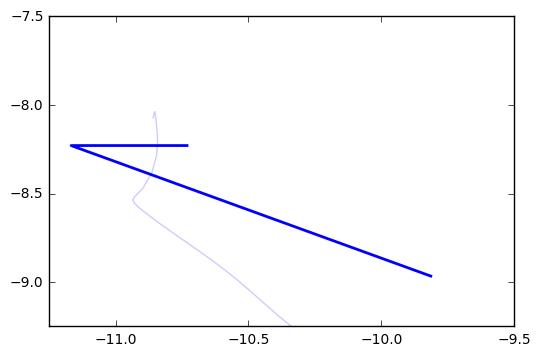

In [4]:
#for hs in human_sounds:
hs = "oiy"
agent.modules["mod13"].sm.sigma_expl = np.array([0.1]*28)
#print agent.modules["mod13"].sm.sigma_expl
m = agent.modules["mod13"].inverse(np.array(environment.human_sounds_traj_std[hs]), explore=True) 
#print m
s = environment.update([0.]*21 + list(m))
s_traj = environment.diva_traj
#print s_traj
error = np.linalg.norm(np.array(environment.human_sounds_traj[hs]) - np.array([f[0] for f in s_traj[[0, 12, 24, 37, 49]]] + [f[1] for f in s_traj[[0, 12, 24, 37, 49]]]))
print "error", hs, error


plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="b", alpha=0.2)    
plt.plot(- np.array(environment.human_sounds_traj[hs][5:]), -np.array(environment.human_sounds_traj[hs][:5]), lw=2)

plt.xlim([-11.25,-9.5])
plt.ylim([-9.25, -7.5])

In [3]:

for i in range(100):
    context = environment.get_current_context()[:4]
    s_goal = [2. * np.random.random() - 1. for _ in range(10)]

    m = agent.modules["mod10"].inverse(np.array(context + s_goal), explore=True)
    m = [0.] * 21 + list(m)
    s = environment.update(m)
    if environment.produced_sound:
        print environment.produced_sound
    agent.perceive(s)

In [3]:
print agent.modules["mod10"].sm.model.imodel.fmodel.dataset.data[1]

[]


In [28]:
def min_dist(human_sounds):
    
    
    v_o = list(np.log2([500, 900]))
    v_y = list(np.log2([300, 1700]))
    v_u = list(np.log2([300, 800]))
    v_e = list(np.log2([400, 2200]))
    v_i = list(np.log2([300, 2300]))


    vowels = dict(o=v_o, y=v_y, u=v_u, e=v_e, i=v_i)    

    def compute_s_sound(sound):
        s1 = vowels[sound[0]]
        s2 = [(vowels[sound[0]][0] + vowels[sound[1]][0]) / 2., (vowels[sound[0]][1] + vowels[sound[1]][1]) / 2.]
        s3 = vowels[sound[1]]
        s4 = [(vowels[sound[1]][0] + vowels[sound[2]][0]) / 2., (vowels[sound[1]][1] + vowels[sound[2]][1]) / 2.]
        s5 = vowels[sound[2]]
        rdm = 0.0 * (2.*np.random.random((1,10))[0] - 1.)
        return list(rdm + np.array([f[0] for f in [s1, s2, s3, s4, s5]] + [f[1] for f in [s1, s2, s3, s4, s5]]))


    human_sounds_traj = dict()
    for hs in human_sounds:
        human_sounds_traj[hs] = compute_s_sound(hs)
            
    min_d = 2.
    for ihs1 in range(6):
        for ihs2 in range(ihs1+1, 6):
            hs1 = human_sounds[ihs1]
            hs2 = human_sounds[ihs2]
            d = np.linalg.norm(np.array(human_sounds_traj[hs1]) - 
                               np.array(human_sounds_traj[hs2]))
            #print hs1, hs2, d
            if d < min_d:
                min_d = d
    return min_d

In [29]:
min_dist(environment.human_sounds)

0.70124966858726867

In [30]:
min_dist(["iuy", "ieu", "euo", "oiy", "yoe", "uie"])

1.0503628481733724

In [75]:
import itertools

sounds = ["oie", "oei", "oey", "oye", "oiy", "oyi", "uie", "uei", "uey", "uye", "uiy", "uyi", 
    "ieo", "ieu", "iyo", "iyu", "iou", "iuo",
    "eio", "eiu", "eyo", "eyu", "eou", "euo", 
    "yio", "yiu", "yeo", "yeu", "you", "yuo"]

max_min_d = 0.
best_sounds = []

it = itertools.combinations(sounds, 6)

try:
    while True:
        hs = list(next(it))
        min_d = min_dist(hs)
        if min_d > max_min_d:
            max_min_d = min_d
            best_sounds = hs
except:
    print max_min_d
    print best_sounds

1.26428500985
['oey', 'uye', 'iuo', 'eyu', 'eou', 'yeo']
